In [1]:
import pandas as pd
import pickle
import numpy as np
import math
import warnings
import model_metrics_helper
from model_metrics_helper import plot_median_first_alert_time
from sklearn.metrics import confusion_matrix

warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
pd.options.display.float_format = '{:,.4f}'.format

### Load Test Data

In [2]:
test_scores_df = pd.read_csv('/gpfs/data/paulab/sepsis_floor_prediction/sepsis_real_time_prediction/model_results/test_set_results_20220704_221130.csv')
test_scores_df.rename(columns={'SepsisTrueLabel':'SepsisLabel'}, inplace=True)
test_scores_df.iloc[:, 1:].head(5)

,LOS,PredictedProbability,SepsisLabel,t_timezero,SepsisLabel_0.005,SepsisLabel_0.01,SepsisLabel_0.02,SepsisLabel_0.03,SepsisLabel_0.04,SepsisLabel_0.05,SepsisLabel_0.06,SepsisLabel_0.07,SepsisLabel_0.09,SepsisLabel_0.1,SepsisLabel_0.15,SepsisLabel_0.2,SepsisLabel_0.25,SepsisLabel_0.3,SepsisLabel_0.4,SepsisLabel_0.5,PredictedProbabilityAblated,SepsisLabel_0.005Ablated,SepsisLabel_0.01Ablated,SepsisLabel_0.02Ablated,SepsisLabel_0.03Ablated,SepsisLabel_0.04Ablated,SepsisLabel_0.05Ablated,SepsisLabel_0.06Ablated,SepsisLabel_0.07Ablated,SepsisLabel_0.09Ablated,SepsisLabel_0.1Ablated,SepsisLabel_0.15Ablated,SepsisLabel_0.2Ablated,SepsisLabel_0.25Ablated,SepsisLabel_0.3Ablated,SepsisLabel_0.4Ablated,SepsisLabel_0.5Ablated
0,0,0.0084,0,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0084,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,0.0044,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0044,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0.0047,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0047,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,0.0042,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0042,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,12,0.0061,0,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0061,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Run SIRS and MEWS for the test data to compare as baselines with ML results at different thresholds

In [3]:
main_df = pd.read_csv("/gpfs/data/paulab/bvg228/sepsis_real_time_prediction/data/NYU_6hr_preprocessed_48hr_main_df_20220526_100348.csv")
main_df = main_df[main_df['ID'].isin(test_scores_df['ID'])]
main_df.rename(columns={'WHITE BLOOD CELL COUNT':'WBC', 'Systolic_BP':'SBP', 'GCS_Score':'gcs_total_score'}, inplace=True)
test_scores_df = test_scores_df.merge(main_df[['ID', 'LOS', 'rel_time']], on=['ID', 'LOS'], how='left')
test_scores_df['rel_time'] = test_scores_df['rel_time'].astype(int)
admission_time = main_df[['ID', 'AdmissionInstant']].drop_duplicates(keep='first')
test_scores_df = test_scores_df.merge(admission_time, on=['ID'], how='left') 
test_scores_df['AlertTime'] = test_scores_df['LOS'] + 1


# SIRS score
SIRS = model_metrics_helper.SIRS(main_df)
SIRS['rel_time'] = SIRS['rel_time'].astype(int)
# MEWS score
MEWS = model_metrics_helper.MEWS(main_df)
MEWS['rel_time'] = MEWS['rel_time'].astype(int)

# merge with prediction results
test_scores_df = test_scores_df.merge(SIRS, on = ['ID', 'rel_time'], how = "left")
test_scores_df = test_scores_df.merge(MEWS, on = ['ID', 'rel_time'], how = "left")

test_scores_df["SIRS"] = test_scores_df["SIRS"] >= 2
test_scores_df["MEWS"] = test_scores_df["MEWS"] >= 5

test_scores_df['SIRS'] = test_scores_df['SIRS'].astype(int)
test_scores_df['MEWS'] = test_scores_df['MEWS'].astype(int)
test_scores_df.rename(columns={'SIRS':'SepsisLabel_SIRS', 'MEWS':'SepsisLabel_MEWS'}, inplace=True)
test_scores_df.iloc[:, 1:].head(5)

,LOS,PredictedProbability,SepsisLabel,t_timezero,SepsisLabel_0.005,SepsisLabel_0.01,SepsisLabel_0.02,SepsisLabel_0.03,SepsisLabel_0.04,SepsisLabel_0.05,SepsisLabel_0.06,SepsisLabel_0.07,SepsisLabel_0.09,SepsisLabel_0.1,SepsisLabel_0.15,SepsisLabel_0.2,SepsisLabel_0.25,SepsisLabel_0.3,SepsisLabel_0.4,SepsisLabel_0.5,PredictedProbabilityAblated,SepsisLabel_0.005Ablated,SepsisLabel_0.01Ablated,SepsisLabel_0.02Ablated,SepsisLabel_0.03Ablated,SepsisLabel_0.04Ablated,SepsisLabel_0.05Ablated,SepsisLabel_0.06Ablated,SepsisLabel_0.07Ablated,SepsisLabel_0.09Ablated,SepsisLabel_0.1Ablated,SepsisLabel_0.15Ablated,SepsisLabel_0.2Ablated,SepsisLabel_0.25Ablated,SepsisLabel_0.3Ablated,SepsisLabel_0.4Ablated,SepsisLabel_0.5Ablated,rel_time,AdmissionInstant,AlertTime,SepsisLabel_SIRS,SepsisLabel_MEWS
0,0,0.0084,0,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0084,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-08-13 21:17:00,1,0,0
1,3,0.0044,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0044,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2015-08-13 21:17:00,4,0,0
2,6,0.0047,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0047,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,2015-08-13 21:17:00,7,0,0
3,9,0.0042,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0042,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,2015-08-13 21:17:00,10,0,0
4,12,0.0061,0,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0061,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,2015-08-13 21:17:00,13,0,0


### Run threshold metrics

In [4]:
def threshold_metrics(df, threshold):
    actual = df["SepsisLabel"]
    predicted = df[f'SepsisLabel_{threshold}']
    tp, fn, fp, tn = confusion_matrix(actual,predicted,labels=[1,0]).reshape(-1)
    
    acc = (tp + tn)/(tp + tn + fn + fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)
    sens = tp/ (tp + fn)
    spec = tn/ (tn + fp)
    f1 = (2*tp) / (2*tp + fp + fn)
    
    return [int(tp), int(fn), int(fp), int(tn), acc, ppv, npv, sens, spec, f1]

def threshold_first_alert(test_scores_df, threshold):
    df = test_scores_df[test_scores_df[f'SepsisLabel_{threshold}'] == 1]
    n_total_possible_sepsis_alerts = df.shape[0]
    n_total_possible_sepsis_alerts_day_yr = n_total_possible_sepsis_alerts / 365.
    df.drop_duplicates(subset=['ID'], keep='first', inplace=True)
    df['LeadTimeValue'] = -(df['t_timezero'] - df['AlertTime'])
    df['abs_time'] = pd.to_datetime(test_scores_df['AdmissionInstant']) + pd.to_timedelta(test_scores_df['AlertTime'], unit='h')
    df['time_to_first_alert'] = (pd.to_datetime(df['abs_time']) - pd.to_datetime(df['AdmissionInstant'])).dt.total_seconds() / 3600.
    
    n_total_first_sepsis_alert = df.shape[0]
    n_total_first_sepsis_alert_day_yr = n_total_first_sepsis_alert / 365.
    df.dropna(subset=['t_timezero'], inplace=True) #there's no false positive. because dropped NA.
    n_tp_first_sepsis_alert = df.shape[0]
    n_early_first_sepsis_alert = df[df['LeadTimeValue'] < 0].shape[0]
    median_first_alert_time = df.groupby(f'SepsisLabel_{threshold}')['LeadTimeValue'].median().values[0]
    mean_first_alert_time_from_admission = df.groupby(f'SepsisLabel_{threshold}')['time_to_first_alert'].mean().values[0]
    return [n_total_possible_sepsis_alerts, n_total_possible_sepsis_alerts_day_yr,  n_total_first_sepsis_alert, n_total_first_sepsis_alert_day_yr, n_tp_first_sepsis_alert, n_early_first_sepsis_alert, median_first_alert_time, mean_first_alert_time_from_admission]

def final_threshold_metric_df(test_scores_df, thresholds):
    threshold_df = pd.DataFrame()
    threshold_df.index = ['tp', 'fn', 'fp', 'tn', 'acc', 'ppv', 'npv', 'sens', 'spec', 'F1']
    for threshold in thresholds:
        threshold_df[f'SepsisLabel_{threshold}'] = threshold_metrics(test_scores_df, threshold)
    threshold_df = threshold_df.T.reset_index().rename(columns={'index':'Threshold'})
    cols_to_int = ['tp', 'fn', 'fp', 'tn']
    for col in cols_to_int:
        threshold_df[col] = threshold_df[col].astype(int)
        
    lead_time_df = pd.DataFrame()
    lead_time_df.index = ['N_Total_Possible_Sepsis_Alerts', 'N_Total_Possible_Sepsis_Alerts_Per_Day', 'N_Total_First_Sepsis_Alert', 'N_Total_First_Sepsis_Alert_Per_Day','N_TP_First_Sepsis_Alert', 'N_Early_First_Sepsis_Alert', 'Median_First_Alert_Time_From_TimeZero', 'Avg_First_Alert_Time_From_Admission']
    for threshold in thresholds:
        lead_time_df[f'SepsisLabel_{threshold}'] = threshold_first_alert(test_scores_df, threshold)
    lead_time_df = lead_time_df.T.reset_index().rename(columns={'index':'Threshold'})
    cols_to_int = ['N_Total_Possible_Sepsis_Alerts', 'N_Total_Possible_Sepsis_Alerts_Per_Day', 'N_Total_First_Sepsis_Alert', 'N_Total_First_Sepsis_Alert_Per_Day','N_TP_First_Sepsis_Alert', 'N_Early_First_Sepsis_Alert']
    for col in cols_to_int:
        lead_time_df[col] = lead_time_df[col].astype(int)
             
    final_df = threshold_df.merge(lead_time_df, on=['Threshold'], how='left')
    final_df['Threshold'] = final_df['Threshold'].apply(lambda x: 'ML_' + x.split('_')[1] if x not in ['SepsisLabel_SIRS', 'SepsisLabel_MEWS'] else x.split('_')[1])
    
    return final_df
    


In [5]:
thresholds = ['SIRS', 'MEWS', 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.09, 0.10, 0.15, 0.20, 0.25, 0.3, 0.4,0.5]
ablated_thresholds = [str(threshold)+ 'Ablated' for threshold in thresholds if threshold not in ['SIRS', 'MEWS']]
thresholds = ablated_thresholds + thresholds

# test scores with full test set
final_df_w_poa = final_threshold_metric_df(test_scores_df, thresholds)

#test scores with t_timezero.isna() OR t_timezero > 1
test_scores_df_no_poa_1 = test_scores_df[(test_scores_df['t_timezero'] > 1) | (test_scores_df['t_timezero'].isna())]
final_df_no_poa_1 = final_threshold_metric_df(test_scores_df_no_poa_1, thresholds)

#test scores with t_timezero.isna() OR t_timezero > 12
test_scores_df_no_poa_12 = test_scores_df[(test_scores_df['t_timezero'] > 12) | (test_scores_df['t_timezero'].isna())]
final_df_no_poa_12 = final_threshold_metric_df(test_scores_df_no_poa_12, thresholds)

#combine all dataframes
data_sources = ['Full Test Set', 
           'Test Set, w/ Encounters t_timezero > 1 hr',
           'Test Set, w/ Encounters t_timezero > 12 hrs']

final_full_df = pd.concat([final_df_w_poa, final_df_no_poa_1, final_df_no_poa_12], keys=data_sources, axis=1)
#final_full_df.to_excel('/gpfs/data/paulab/sepsis_floor_prediction/sepsis_real_time_prediction/model_results/threshold_metrics_20220627_172236.xlsx')
final_full_df

Full Test Set                                                        \
          Threshold    tp    fn     fp     tn    acc    ppv    npv   sens   
0   ML_0.005Ablated  9514     3  66848  24716 0.3386 0.1246 0.9999 0.9997   
1    ML_0.01Ablated  9498    19  47505  44059 0.5298 0.1666 0.9996 0.9980   
2    ML_0.02Ablated  9435    82  31767  59797 0.6849 0.2290 0.9986 0.9914   
3    ML_0.03Ablated  9298   219  24347  67217 0.7570 0.2764 0.9968 0.9770   
4    ML_0.04Ablated  9170   347  19890  71674 0.7998 0.3156 0.9952 0.9635   
5    ML_0.05Ablated  9048   469  16958  74606 0.8276 0.3479 0.9938 0.9507   
6    ML_0.06Ablated  8973   544  14754  76810 0.8487 0.3782 0.9930 0.9428   
7    ML_0.07Ablated  8862   655  13142  78422 0.8635 0.4027 0.9917 0.9312   
8    ML_0.09Ablated  8690   827  10717  80847 0.8858 0.4478 0.9899 0.9131   
9     ML_0.1Ablated  8598   919   9729  81835 0.8947 0.4691 0.9889 0.9034   
10   ML_0.15Ablated  8193  1324   6771  84793 0.9199 0.5475 0.9846 0.8609   
11    ML_0.2Ablated  7807  1710   5132  86432 0.9323 0.6034 0.9806 0.8203   
12   ML_0.25Ablated  7442  2075   4041  87523 0.9395 0.6481 0.9768 0.7820   
13    ML_0.3Ablated  7032  2485   3204  88360 0.9437 0.6870 0.9726 0.7389   
14    ML_0.4Ablated  6351  3166   2152  89412 0.9474 0.7469 0.9658 0.6673   
15    ML_0.5Ablated  5593  3924   1481  90083 0.9465 0.7906 0.9583 0.5877   
16             SIRS  5422  4095  11378  80186 0.8469 0.3227 0.9514 0.5697   
17             MEWS  1534  7983   1096  90468 0.9102 0.5833 0.9189 0.1612   
18         ML_0.005  9514     3  66795  24769 0.3392 0.1247 0.9999 0.9997   
19          ML_0.01  9498    19  47441  44123 0.5305 0.1668 0.9996 0.9980   
20          ML_0.02  9435    82  31722  59842 0.6854 0.2292 0.9986 0.9914   
21          ML_0.03  9297   220  24323  67241 0.7572 0.2765 0.9967 0.9769   
22          ML_0.04  9172   345  19869  71695 0.8000 0.3158 0.9952 0.9637   
23          ML_0.05  9047   470  16934  74630 0.8278 0.3482 0.9937 0.9506   
24          ML_0.06  8972   545  14737  76827 0.8488 0.3784 0.9930 0.9427   
25          ML_0.07  8860   657  13136  78428 0.8635 0.4028 0.9917 0.9310   
26          ML_0.09  8694   823  10696  80868 0.8860 0.4484 0.9899 0.9135   
27           ML_0.1  8594   923   9704  81860 0.8949 0.4697 0.9889 0.9030   
28          ML_0.15  8200  1317   6762  84802 0.9201 0.5481 0.9847 0.8616   
29           ML_0.2  7812  1705   5128  86436 0.9324 0.6037 0.9807 0.8208   
30          ML_0.25  7444  2073   4024  87540 0.9397 0.6491 0.9769 0.7822   
31           ML_0.3  7032  2485   3199  88365 0.9438 0.6873 0.9726 0.7389   
32           ML_0.4  6351  3166   2151  89413 0.9474 0.7470 0.9658 0.6673   
33           ML_0.5  5597  3920   1476  90088 0.9466 0.7913 0.9583 0.5881   

                                                 \
     spec     F1 N_Total_Possible_Sepsis_Alerts   
0  0.2699 0.2216                          76362   
1  0.4812 0.2856                          57003   
2  0.6531 0.3720                          41202   
3  0.7341 0.4308                          33645   
4  0.7828 0.4754                          29060   
5  0.8148 0.5094                          26006   
6  0.8389 0.5398                          23727   
7  0.8565 0.5623                          22004   
8  0.8830 0.6009                          19407   
9  0.8937 0.6176                          18327   
10 0.9261 0.6693                          14964   
11 0.9440 0.6953                          12939   
12 0.9559 0.7088                          11483   
13 0.9650 0.7120                          10236   
14 0.9765 0.7049                           8503   
15 0.9838 0.6742                           7074   
16 0.8757 0.4121                          16800   
17 0.9880 0.2526                           2630   
18 0.2705 0.2217                          76309   
19 0.4819 0.2858                          56939   
20 0.6536 0.3724                          41157   
21 0.7344 0.4310                          33620   
22 0.7830

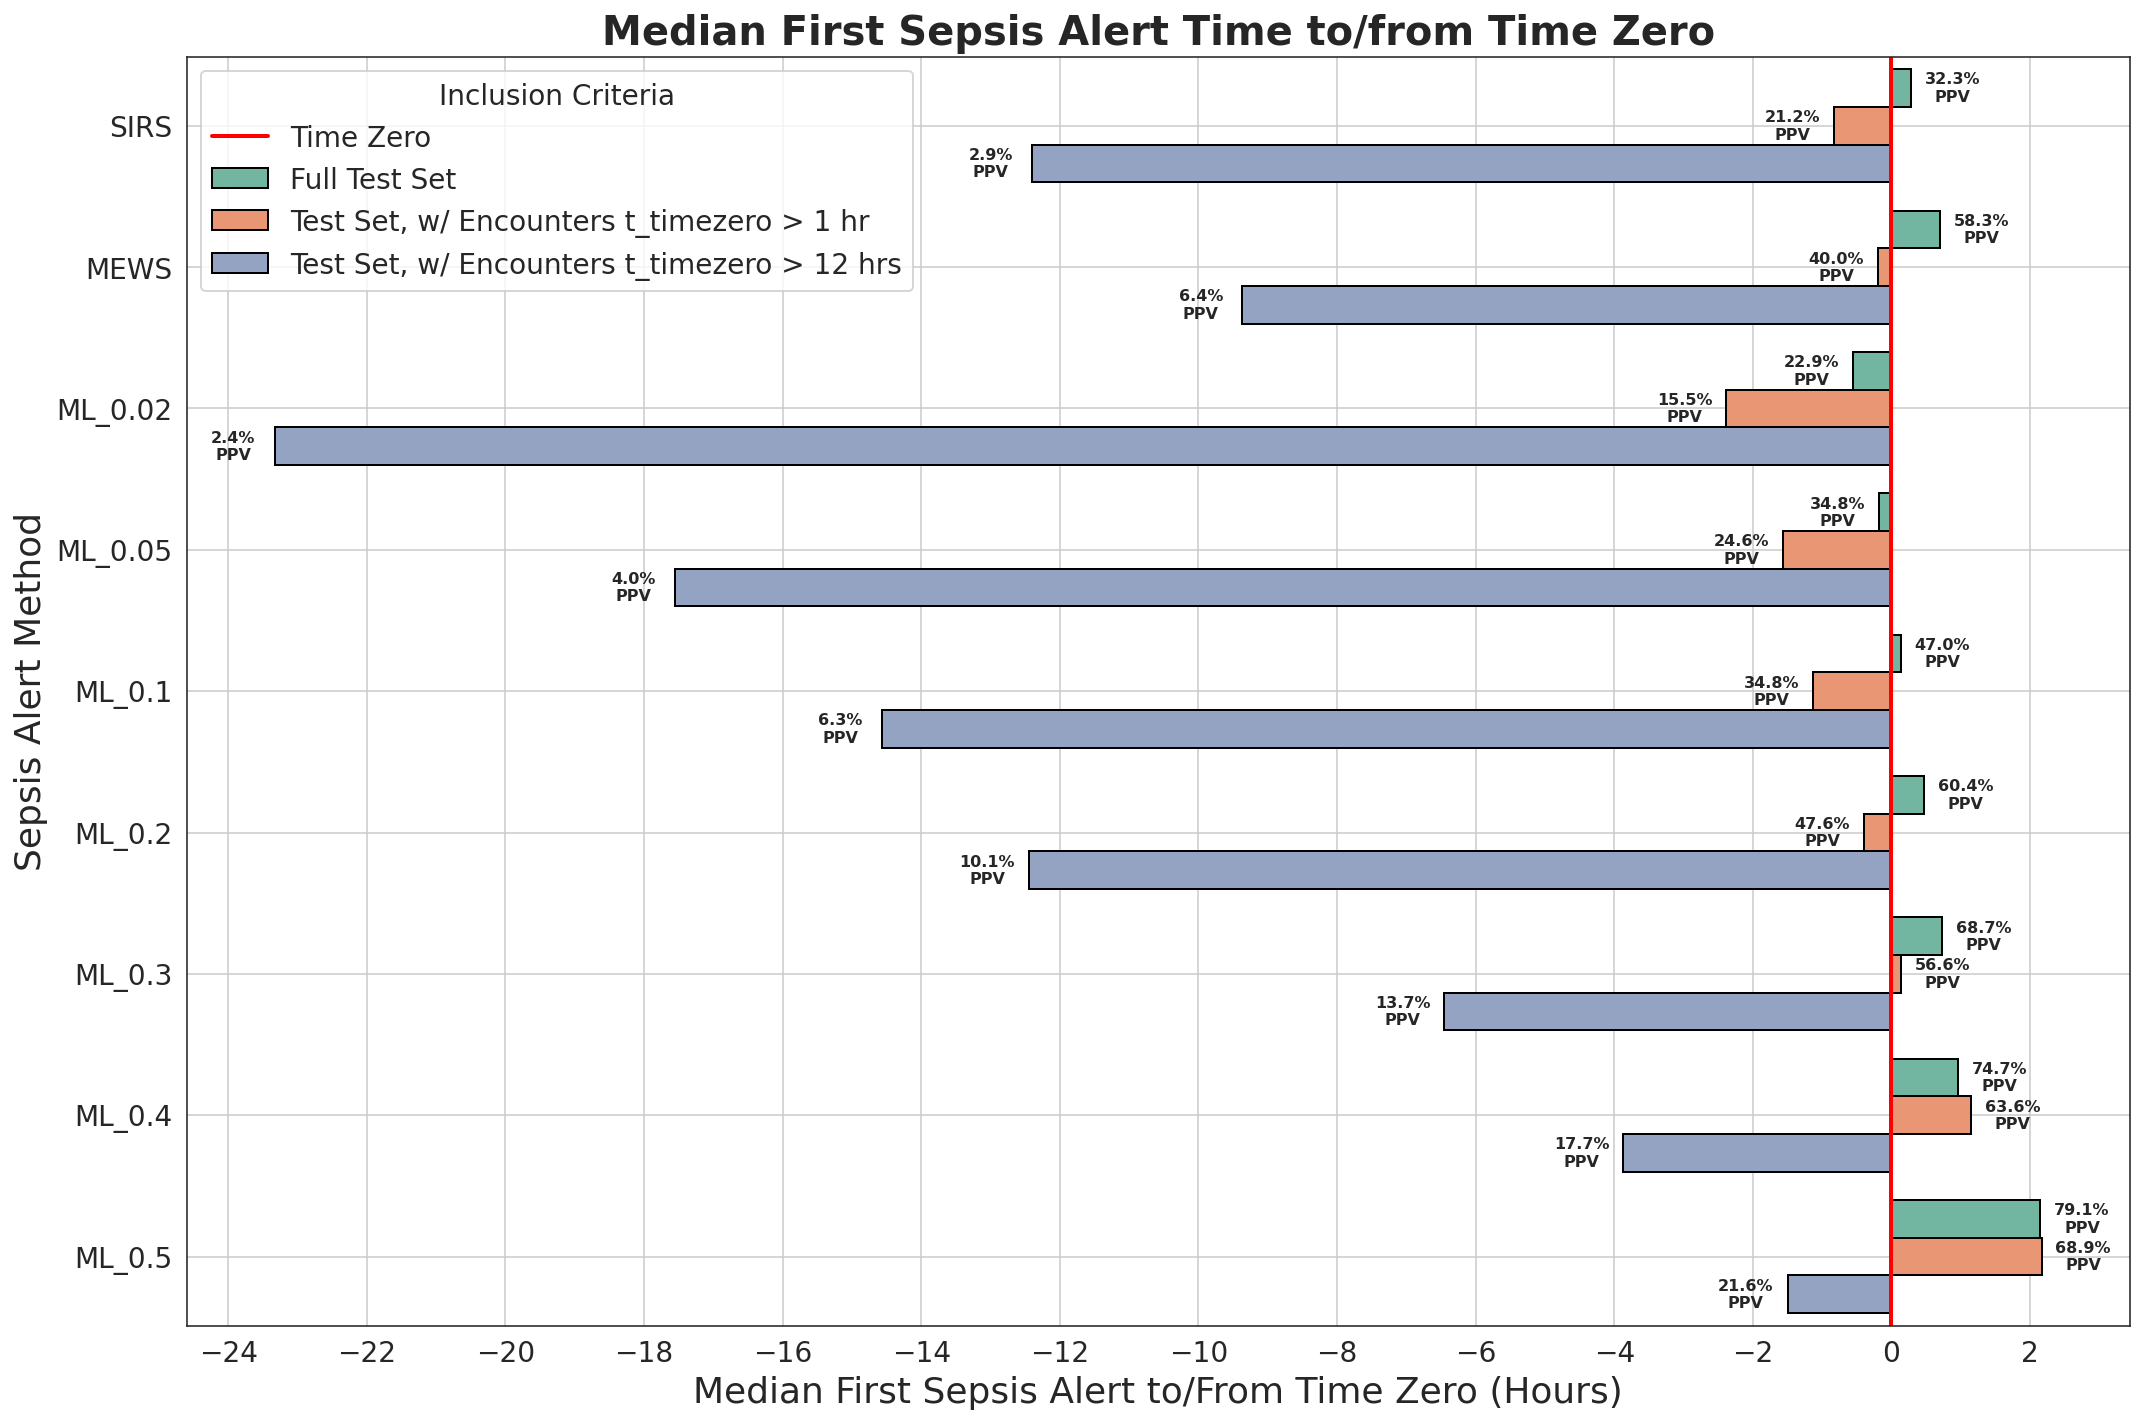

In [6]:
# select thresholds to include in the plot
plot_thresholds = ['SIRS', 'MEWS', 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
plot_median_first_alert_time(final_df_w_poa, final_df_no_poa_1, final_df_no_poa_12, data_sources, plot_thresholds)